<a href="https://colab.research.google.com/github/RBENJAMINFRANKLIN/SBSPS-Challenge-1160-Predicting-the-energy-output-of-wind-turbine-based-on-weather-condition/blob/master/SBSPS-Challenge-1160-Predicting-the-energy-output-of-wind-turbine-based-on-weather-condition/03%20Building%20Models%20-%20Deep%20Learning%20Models/winddirectionlstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [2]:
batch_size_exp = 1
epoch_exp = 7
neurons_exp = 10
predict_values_exp = 6000
lag_exp=72

In [3]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [4]:

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [5]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [6]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [7]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
    

In [8]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(50))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    return model


In [9]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [10]:

''' Loading data '''
import pandas as pd
series = pd.read_csv('../data/T1.csv',index_col="Date/Time")
series.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
Date/Time,,,,
01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [11]:
#del series['Air temperature | (\'C)']
del series['LV ActivePower (kW)']
del series['Wind Speed (m/s)']
del series['Theoretical_Power_Curve (KWh)']
series.head()

,Wind Direction (°)
Date/Time,
01 01 2018 00:00,259.994904
01 01 2018 00:10,268.641113
01 01 2018 00:20,272.564789
01 01 2018 00:30,271.258087
01 01 2018 00:40,265.674286


In [12]:
for i in range(0,10):
  series = series[:-1]
series.tail()


,Wind Direction (°)
Date/Time,
31 12 2018 21:30,79.699562
31 12 2018 21:40,80.132507
31 12 2018 21:50,80.081612
31 12 2018 22:00,80.452248
31 12 2018 22:10,80.960693


In [13]:
  series.shape

(50520, 1)

In [14]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [15]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

# print(supervised_values)

In [16]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [17]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [18]:
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


44519/44519 [==============================] - 121s 3ms/step - loss: 0.0101


In [19]:
predictions = list()
expectations = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 1s 1s/step
Hour=1, Predicted=243.936993, Expected=225.140594
1/1 [==============================] - 0s 31ms/step
Hour=2, Predicted=230.234216, Expected=218.255402
1/1 [==============================] - 0s 28ms/step
Hour=3, Predicted=211.992780, Expected=216.909805
1/1 [==============================] - 0s 45ms/step
Hour=4, Predicted=220.522036, Expected=218.613296
1/1 [==============================] - 0s 33ms/step
Hour=5, Predicted=218.739796, Expected=216.620895
1/1 [==============================] - 0s 50ms/step
Hour=6, Predicted=218.304120, Expected=219.013702
1/1 [==============================] - 0s 38ms/step
Hour=7, Predicted=218.984698, Expected=212.312805
1/1 [==============================] - 0s 35ms/step
Hour=8, Predicted=213.678928, Expected=208.537399
1/1 [==============================] - 0s 30ms/step
Hour=9, Predicted=210.194279, Expected=209.072601
1/1 [==============================] - 0s 44ms/step
Hour=10, Predicted=209.456555, E

1/1 [==============================] - 0s 46ms/step
Hour=81, Predicted=197.760871, Expected=201.700104
1/1 [==============================] - 0s 76ms/step
Hour=82, Predicted=201.812555, Expected=201.533997
1/1 [==============================] - 0s 54ms/step
Hour=83, Predicted=202.498272, Expected=199.482697
1/1 [==============================] - 0s 39ms/step
Hour=84, Predicted=199.875350, Expected=203.738800
1/1 [==============================] - 0s 45ms/step
Hour=85, Predicted=204.139377, Expected=207.278198
1/1 [==============================] - 0s 40ms/step
Hour=86, Predicted=207.852475, Expected=204.721603
1/1 [==============================] - 0s 40ms/step
Hour=87, Predicted=205.545737, Expected=205.581406
1/1 [==============================] - 0s 30ms/step
Hour=88, Predicted=205.565447, Expected=204.078705
1/1 [==============================] - 0s 34ms/step
Hour=89, Predicted=204.408974, Expected=202.978500
1/1 [==============================] - 0s 35ms/step
Hour=90, Predicted=20

1/1 [==============================] - 0s 26ms/step
Hour=160, Predicted=151.054400, Expected=154.562897
1/1 [==============================] - 0s 29ms/step
Hour=161, Predicted=155.155874, Expected=154.137695
1/1 [==============================] - 0s 27ms/step
Hour=162, Predicted=154.519451, Expected=146.974503
1/1 [==============================] - 0s 25ms/step
Hour=163, Predicted=147.446534, Expected=141.309601
1/1 [==============================] - 0s 26ms/step
Hour=164, Predicted=141.757800, Expected=141.563095
1/1 [==============================] - 0s 26ms/step
Hour=165, Predicted=142.124592, Expected=147.390198
1/1 [==============================] - 0s 28ms/step
Hour=166, Predicted=147.905393, Expected=151.616699
1/1 [==============================] - 0s 26ms/step
Hour=167, Predicted=151.882340, Expected=148.486801
1/1 [==============================] - 0s 28ms/step
Hour=168, Predicted=149.210345, Expected=145.517303
1/1 [==============================] - 0s 28ms/step
Hour=169, Pr

1/1 [==============================] - 0s 26ms/step
Hour=239, Predicted=206.718190, Expected=206.275207
1/1 [==============================] - 0s 27ms/step
Hour=240, Predicted=206.666636, Expected=201.268799
1/1 [==============================] - 0s 26ms/step
Hour=241, Predicted=201.687750, Expected=205.813202
1/1 [==============================] - 0s 27ms/step
Hour=242, Predicted=206.312461, Expected=208.708893
1/1 [==============================] - 0s 27ms/step
Hour=243, Predicted=209.136311, Expected=203.410294
1/1 [==============================] - 0s 25ms/step
Hour=244, Predicted=203.876216, Expected=204.737106
1/1 [==============================] - 0s 28ms/step
Hour=245, Predicted=205.161978, Expected=201.038696
1/1 [==============================] - 0s 33ms/step
Hour=246, Predicted=201.523157, Expected=199.990204
1/1 [==============================] - 0s 36ms/step
Hour=247, Predicted=200.459548, Expected=201.920395
1/1 [==============================] - 0s 34ms/step
Hour=248, Pr

1/1 [==============================] - 0s 27ms/step
Hour=318, Predicted=23.984026, Expected=21.879471
1/1 [==============================] - 0s 26ms/step
Hour=319, Predicted=22.280590, Expected=29.033510
1/1 [==============================] - 0s 26ms/step
Hour=320, Predicted=29.516509, Expected=26.513760
1/1 [==============================] - 0s 27ms/step
Hour=321, Predicted=26.950752, Expected=26.233650
1/1 [==============================] - 0s 26ms/step
Hour=322, Predicted=26.674366, Expected=33.091190
1/1 [==============================] - 0s 29ms/step
Hour=323, Predicted=33.554460, Expected=34.386311
1/1 [==============================] - 0s 26ms/step
Hour=324, Predicted=34.812109, Expected=42.811272
1/1 [==============================] - 0s 26ms/step
Hour=325, Predicted=43.294320, Expected=41.845440
1/1 [==============================] - 0s 30ms/step
Hour=326, Predicted=42.266952, Expected=41.269081
1/1 [==============================] - 0s 29ms/step
Hour=327, Predicted=41.716948,

1/1 [==============================] - 0s 26ms/step
Hour=398, Predicted=36.591066, Expected=33.567261
1/1 [==============================] - 0s 27ms/step
Hour=399, Predicted=34.034098, Expected=32.770012
1/1 [==============================] - 0s 27ms/step
Hour=400, Predicted=33.201026, Expected=35.844681
1/1 [==============================] - 0s 29ms/step
Hour=401, Predicted=36.302611, Expected=33.447350
1/1 [==============================] - 0s 28ms/step
Hour=402, Predicted=33.899213, Expected=33.666260
1/1 [==============================] - 0s 26ms/step
Hour=403, Predicted=34.105468, Expected=32.199699
1/1 [==============================] - 0s 26ms/step
Hour=404, Predicted=32.663312, Expected=32.532989
1/1 [==============================] - 0s 28ms/step
Hour=405, Predicted=32.968854, Expected=35.493721
1/1 [==============================] - 0s 27ms/step
Hour=406, Predicted=35.950834, Expected=36.050671
1/1 [==============================] - 0s 26ms/step
Hour=407, Predicted=36.506627,

1/1 [==============================] - 0s 29ms/step
Hour=478, Predicted=37.183647, Expected=34.977200
1/1 [==============================] - 0s 26ms/step
Hour=479, Predicted=35.421024, Expected=32.668030
1/1 [==============================] - 0s 34ms/step
Hour=480, Predicted=33.124031, Expected=34.408470
1/1 [==============================] - 0s 50ms/step
Hour=481, Predicted=34.856832, Expected=31.075380
1/1 [==============================] - 0s 41ms/step
Hour=482, Predicted=31.522683, Expected=29.503059
1/1 [==============================] - 0s 31ms/step
Hour=483, Predicted=29.958238, Expected=30.717600
1/1 [==============================] - 0s 27ms/step
Hour=484, Predicted=31.163705, Expected=32.770260
1/1 [==============================] - 0s 26ms/step
Hour=485, Predicted=33.222252, Expected=31.064341
1/1 [==============================] - 0s 50ms/step
Hour=486, Predicted=31.515553, Expected=33.522549
1/1 [==============================] - 0s 39ms/step
Hour=487, Predicted=33.969641,

1/1 [==============================] - 0s 27ms/step
Hour=558, Predicted=64.842988, Expected=64.156776
1/1 [==============================] - 0s 26ms/step
Hour=559, Predicted=64.608561, Expected=68.198463
1/1 [==============================] - 0s 26ms/step
Hour=560, Predicted=68.648359, Expected=70.296127
1/1 [==============================] - 0s 32ms/step
Hour=561, Predicted=70.746051, Expected=68.500427
1/1 [==============================] - 0s 25ms/step
Hour=562, Predicted=68.952389, Expected=71.674606
1/1 [==============================] - 0s 26ms/step
Hour=563, Predicted=72.124017, Expected=68.966042
1/1 [==============================] - 0s 25ms/step
Hour=564, Predicted=69.416524, Expected=69.226578
1/1 [==============================] - 0s 28ms/step
Hour=565, Predicted=69.678185, Expected=65.745483
1/1 [==============================] - 0s 26ms/step
Hour=566, Predicted=66.194846, Expected=62.856159
1/1 [==============================] - 0s 28ms/step
Hour=567, Predicted=63.307271,

1/1 [==============================] - 0s 26ms/step
Hour=638, Predicted=62.925492, Expected=64.317108
1/1 [==============================] - 0s 28ms/step
Hour=639, Predicted=64.767966, Expected=63.143639
1/1 [==============================] - 0s 25ms/step
Hour=640, Predicted=63.593852, Expected=61.695431
1/1 [==============================] - 0s 28ms/step
Hour=641, Predicted=62.146606, Expected=59.963440
1/1 [==============================] - 0s 30ms/step
Hour=642, Predicted=60.413779, Expected=64.172394
1/1 [==============================] - 0s 26ms/step
Hour=643, Predicted=64.622891, Expected=62.265362
1/1 [==============================] - 0s 27ms/step
Hour=644, Predicted=62.716648, Expected=61.452389
1/1 [==============================] - 0s 25ms/step
Hour=645, Predicted=61.902303, Expected=60.377239
1/1 [==============================] - 0s 26ms/step
Hour=646, Predicted=60.828247, Expected=61.063000
1/1 [==============================] - 0s 28ms/step
Hour=647, Predicted=61.513927,

1/1 [==============================] - 0s 26ms/step
Hour=717, Predicted=237.079712, Expected=235.122406
1/1 [==============================] - 0s 26ms/step
Hour=718, Predicted=235.573245, Expected=230.499100
1/1 [==============================] - 0s 29ms/step
Hour=719, Predicted=230.949497, Expected=228.514297
1/1 [==============================] - 0s 26ms/step
Hour=720, Predicted=228.965282, Expected=222.720398
1/1 [==============================] - 0s 26ms/step
Hour=721, Predicted=223.170942, Expected=222.129394
1/1 [==============================] - 0s 29ms/step
Hour=722, Predicted=222.580034, Expected=231.436203
1/1 [==============================] - 0s 26ms/step
Hour=723, Predicted=231.887142, Expected=244.197296
1/1 [==============================] - 0s 26ms/step
Hour=724, Predicted=244.647668, Expected=224.802704
1/1 [==============================] - 0s 27ms/step
Hour=725, Predicted=225.253627, Expected=224.598602
1/1 [==============================] - 0s 26ms/step
Hour=726, Pr

1/1 [==============================] - 0s 27ms/step
Hour=796, Predicted=200.337097, Expected=196.090500
1/1 [==============================] - 0s 26ms/step
Hour=797, Predicted=196.541220, Expected=195.993897
1/1 [==============================] - 0s 30ms/step
Hour=798, Predicted=196.444493, Expected=195.329193
1/1 [==============================] - 0s 27ms/step
Hour=799, Predicted=195.780035, Expected=198.194397
1/1 [==============================] - 0s 26ms/step
Hour=800, Predicted=198.645019, Expected=197.446198
1/1 [==============================] - 0s 26ms/step
Hour=801, Predicted=197.896897, Expected=194.510406
1/1 [==============================] - 0s 52ms/step
Hour=802, Predicted=194.961192, Expected=193.667892
1/1 [==============================] - 0s 36ms/step
Hour=803, Predicted=194.118489, Expected=192.582504
1/1 [==============================] - 0s 41ms/step
Hour=804, Predicted=193.033298, Expected=197.702805
1/1 [==============================] - 0s 29ms/step
Hour=805, Pr

1/1 [==============================] - 0s 42ms/step
Hour=875, Predicted=194.570542, Expected=192.152298
1/1 [==============================] - 0s 39ms/step
Hour=876, Predicted=192.603002, Expected=191.974503
1/1 [==============================] - 0s 39ms/step
Hour=877, Predicted=192.425183, Expected=188.310806
1/1 [==============================] - 0s 37ms/step
Hour=878, Predicted=188.761558, Expected=191.120697
1/1 [==============================] - 0s 42ms/step
Hour=879, Predicted=191.571374, Expected=192.064102
1/1 [==============================] - 0s 43ms/step
Hour=880, Predicted=192.514814, Expected=191.118897
1/1 [==============================] - 0s 36ms/step
Hour=881, Predicted=191.569627, Expected=188.488602
1/1 [==============================] - 0s 36ms/step
Hour=882, Predicted=188.939273, Expected=189.864502
1/1 [==============================] - 0s 37ms/step
Hour=883, Predicted=190.315238, Expected=190.677307
1/1 [==============================] - 0s 36ms/step
Hour=884, Pr

1/1 [==============================] - 0s 26ms/step
Hour=954, Predicted=194.735816, Expected=196.682495
1/1 [==============================] - 0s 62ms/step
Hour=955, Predicted=197.133200, Expected=196.353805
1/1 [==============================] - 0s 28ms/step
Hour=956, Predicted=196.804506, Expected=198.031692
1/1 [==============================] - 0s 27ms/step
Hour=957, Predicted=198.482412, Expected=198.831497
1/1 [==============================] - 0s 27ms/step
Hour=958, Predicted=199.282195, Expected=200.928299
1/1 [==============================] - 0s 29ms/step
Hour=959, Predicted=201.379011, Expected=201.268204
1/1 [==============================] - 0s 34ms/step
Hour=960, Predicted=201.718923, Expected=200.480606
1/1 [==============================] - 0s 30ms/step
Hour=961, Predicted=200.931302, Expected=197.471497
1/1 [==============================] - 0s 31ms/step
Hour=962, Predicted=197.922215, Expected=195.794998
1/1 [==============================] - 0s 31ms/step
Hour=963, Pr

Hour=1032, Predicted=201.768407, Expected=200.696198
1/1 [==============================] - 0s 53ms/step
Hour=1033, Predicted=201.146912, Expected=199.327103
1/1 [==============================] - 0s 44ms/step
Hour=1034, Predicted=199.777809, Expected=200.992203
1/1 [==============================] - 0s 46ms/step
Hour=1035, Predicted=201.442905, Expected=198.459793
1/1 [==============================] - 0s 55ms/step
Hour=1036, Predicted=198.910513, Expected=197.789398
1/1 [==============================] - 0s 45ms/step
Hour=1037, Predicted=198.240103, Expected=196.728394
1/1 [==============================] - 0s 47ms/step
Hour=1038, Predicted=197.179101, Expected=197.153595
1/1 [==============================] - 0s 96ms/step
Hour=1039, Predicted=197.604304, Expected=198.567200
1/1 [==============================] - 0s 61ms/step
Hour=1040, Predicted=199.017902, Expected=198.829300
1/1 [==============================] - 0s 48ms/step
Hour=1041, Predicted=199.280014, Expected=195.686798
1/

1/1 [==============================] - 0s 26ms/step
Hour=1111, Predicted=182.140401, Expected=183.139404
1/1 [==============================] - 0s 25ms/step
Hour=1112, Predicted=183.590112, Expected=181.489807
1/1 [==============================] - 0s 26ms/step
Hour=1113, Predicted=181.940516, Expected=182.976593
1/1 [==============================] - 0s 26ms/step
Hour=1114, Predicted=183.427302, Expected=178.954193
1/1 [==============================] - 0s 27ms/step
Hour=1115, Predicted=179.404903, Expected=181.955795
1/1 [==============================] - 0s 27ms/step
Hour=1116, Predicted=182.406503, Expected=180.261902
1/1 [==============================] - 0s 40ms/step
Hour=1117, Predicted=180.712608, Expected=180.865494
1/1 [==============================] - 0s 42ms/step
Hour=1118, Predicted=181.316203, Expected=180.578293
1/1 [==============================] - 0s 28ms/step
Hour=1119, Predicted=181.029002, Expected=178.356293
1/1 [==============================] - 0s 27ms/step
Hou

1/1 [==============================] - 0s 41ms/step
Hour=1189, Predicted=182.416103, Expected=183.996002
1/1 [==============================] - 0s 31ms/step
Hour=1190, Predicted=184.446707, Expected=176.631103
1/1 [==============================] - 0s 34ms/step
Hour=1191, Predicted=177.081812, Expected=184.574905
1/1 [==============================] - 0s 37ms/step
Hour=1192, Predicted=185.025614, Expected=186.217499
1/1 [==============================] - 0s 38ms/step
Hour=1193, Predicted=186.668201, Expected=189.218796
1/1 [==============================] - 0s 39ms/step
Hour=1194, Predicted=189.669507, Expected=187.562698
1/1 [==============================] - 0s 73ms/step
Hour=1195, Predicted=188.013406, Expected=189.748001
1/1 [==============================] - 0s 60ms/step
Hour=1196, Predicted=190.198707, Expected=189.832306
1/1 [==============================] - 0s 43ms/step
Hour=1197, Predicted=190.283015, Expected=190.179993
1/1 [==============================] - 0s 69ms/step
Hou

1/1 [==============================] - 0s 34ms/step
Hour=1268, Predicted=21.592000, Expected=25.011980
1/1 [==============================] - 0s 44ms/step
Hour=1269, Predicted=25.462689, Expected=22.076981
1/1 [==============================] - 0s 38ms/step
Hour=1270, Predicted=22.527691, Expected=28.088079
1/1 [==============================] - 0s 39ms/step
Hour=1271, Predicted=28.538786, Expected=26.274561
1/1 [==============================] - 0s 35ms/step
Hour=1272, Predicted=26.725270, Expected=26.802830
1/1 [==============================] - 0s 36ms/step
Hour=1273, Predicted=27.253540, Expected=30.443541
1/1 [==============================] - 0s 44ms/step
Hour=1274, Predicted=30.894245, Expected=29.235279
1/1 [==============================] - 0s 51ms/step
Hour=1275, Predicted=29.685988, Expected=32.601459
1/1 [==============================] - 0s 54ms/step
Hour=1276, Predicted=33.052170, Expected=28.710131
1/1 [==============================] - 0s 36ms/step
Hour=1277, Predicted=

1/1 [==============================] - 0s 36ms/step
Hour=1348, Predicted=34.826611, Expected=32.524059
1/1 [==============================] - 0s 33ms/step
Hour=1349, Predicted=32.974766, Expected=31.991779
1/1 [==============================] - 0s 30ms/step
Hour=1350, Predicted=32.442488, Expected=31.726730
1/1 [==============================] - 0s 39ms/step
Hour=1351, Predicted=32.177439, Expected=30.872761
1/1 [==============================] - 0s 35ms/step
Hour=1352, Predicted=31.323470, Expected=32.805161
1/1 [==============================] - 0s 30ms/step
Hour=1353, Predicted=33.255865, Expected=32.432869
1/1 [==============================] - 0s 36ms/step
Hour=1354, Predicted=32.883579, Expected=32.968189
1/1 [==============================] - 0s 35ms/step
Hour=1355, Predicted=33.418901, Expected=35.676449
1/1 [==============================] - 0s 34ms/step
Hour=1356, Predicted=36.127155, Expected=32.511490
1/1 [==============================] - 0s 42ms/step
Hour=1357, Predicted=

1/1 [==============================] - 0s 26ms/step
Hour=1428, Predicted=34.448483, Expected=33.347858
1/1 [==============================] - 0s 26ms/step
Hour=1429, Predicted=33.798570, Expected=33.854340
1/1 [==============================] - 0s 25ms/step
Hour=1430, Predicted=34.305049, Expected=32.140800
1/1 [==============================] - 0s 25ms/step
Hour=1431, Predicted=32.591507, Expected=34.664490
1/1 [==============================] - 0s 24ms/step
Hour=1432, Predicted=35.115199, Expected=33.686100
1/1 [==============================] - 0s 26ms/step
Hour=1433, Predicted=34.136810, Expected=36.751011
1/1 [==============================] - 0s 26ms/step
Hour=1434, Predicted=37.201718, Expected=36.421791
1/1 [==============================] - 0s 26ms/step
Hour=1435, Predicted=36.872500, Expected=31.053190
1/1 [==============================] - 0s 28ms/step
Hour=1436, Predicted=31.503896, Expected=32.548969
1/1 [==============================] - 0s 28ms/step
Hour=1437, Predicted=

1/1 [==============================] - 0s 28ms/step
Hour=1508, Predicted=25.558001, Expected=26.404169
1/1 [==============================] - 0s 26ms/step
Hour=1509, Predicted=26.854877, Expected=24.460590
1/1 [==============================] - 0s 26ms/step
Hour=1510, Predicted=24.911295, Expected=25.606510
1/1 [==============================] - 0s 26ms/step
Hour=1511, Predicted=26.057222, Expected=26.430740
1/1 [==============================] - 0s 25ms/step
Hour=1512, Predicted=26.881448, Expected=25.807150
1/1 [==============================] - 0s 28ms/step
Hour=1513, Predicted=26.257856, Expected=25.328920
1/1 [==============================] - 0s 24ms/step
Hour=1514, Predicted=25.779628, Expected=25.929279
1/1 [==============================] - 0s 25ms/step
Hour=1515, Predicted=26.379990, Expected=24.988390
1/1 [==============================] - 0s 26ms/step
Hour=1516, Predicted=25.439098, Expected=25.759319
1/1 [==============================] - 0s 26ms/step
Hour=1517, Predicted=

1/1 [==============================] - 0s 27ms/step
Hour=1588, Predicted=69.289488, Expected=72.762222
1/1 [==============================] - 0s 25ms/step
Hour=1589, Predicted=73.212930, Expected=66.618019
1/1 [==============================] - 0s 24ms/step
Hour=1590, Predicted=67.068729, Expected=70.705963
1/1 [==============================] - 0s 26ms/step
Hour=1591, Predicted=71.156668, Expected=70.554359
1/1 [==============================] - 0s 25ms/step
Hour=1592, Predicted=71.005066, Expected=73.535896
1/1 [==============================] - 0s 26ms/step
Hour=1593, Predicted=73.986611, Expected=73.435730
1/1 [==============================] - 0s 26ms/step
Hour=1594, Predicted=73.886436, Expected=78.198471
1/1 [==============================] - 0s 26ms/step
Hour=1595, Predicted=78.649175, Expected=87.750580
1/1 [==============================] - 0s 26ms/step
Hour=1596, Predicted=88.201291, Expected=89.903450
1/1 [==============================] - 0s 26ms/step
Hour=1597, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=1667, Predicted=111.665205, Expected=115.747498
1/1 [==============================] - 0s 29ms/step
Hour=1668, Predicted=116.198205, Expected=111.351501
1/1 [==============================] - 0s 26ms/step
Hour=1669, Predicted=111.802213, Expected=102.576500
1/1 [==============================] - 0s 28ms/step
Hour=1670, Predicted=103.027205, Expected=91.003464
1/1 [==============================] - 0s 25ms/step
Hour=1671, Predicted=91.454173, Expected=98.735313
1/1 [==============================] - 0s 26ms/step
Hour=1672, Predicted=99.186026, Expected=94.930946
1/1 [==============================] - 0s 28ms/step
Hour=1673, Predicted=95.381651, Expected=103.503799
1/1 [==============================] - 0s 26ms/step
Hour=1674, Predicted=103.954506, Expected=102.324799
1/1 [==============================] - 0s 26ms/step
Hour=1675, Predicted=102.775510, Expected=102.754799
1/1 [==============================] - 0s 25ms/step
Hour=1676

1/1 [==============================] - 0s 29ms/step
Hour=1746, Predicted=130.931710, Expected=126.109100
1/1 [==============================] - 0s 29ms/step
Hour=1747, Predicted=126.559808, Expected=120.521500
1/1 [==============================] - 0s 33ms/step
Hour=1748, Predicted=120.972207, Expected=123.176598
1/1 [==============================] - 0s 32ms/step
Hour=1749, Predicted=123.627303, Expected=121.699097
1/1 [==============================] - 0s 34ms/step
Hour=1750, Predicted=122.149806, Expected=125.116798
1/1 [==============================] - 0s 31ms/step
Hour=1751, Predicted=125.567510, Expected=123.861702
1/1 [==============================] - 0s 35ms/step
Hour=1752, Predicted=124.312406, Expected=131.569107
1/1 [==============================] - 0s 28ms/step
Hour=1753, Predicted=132.019816, Expected=164.643204
1/1 [==============================] - 0s 25ms/step
Hour=1754, Predicted=165.093917, Expected=158.742706
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 28ms/step
Hour=1824, Predicted=111.909001, Expected=106.026100
1/1 [==============================] - 0s 28ms/step
Hour=1825, Predicted=106.476813, Expected=85.752739
1/1 [==============================] - 0s 27ms/step
Hour=1826, Predicted=86.203445, Expected=91.021591
1/1 [==============================] - 0s 26ms/step
Hour=1827, Predicted=91.472299, Expected=93.661537
1/1 [==============================] - 0s 27ms/step
Hour=1828, Predicted=94.112249, Expected=101.237900
1/1 [==============================] - 0s 27ms/step
Hour=1829, Predicted=101.688610, Expected=112.726601
1/1 [==============================] - 0s 26ms/step
Hour=1830, Predicted=113.177306, Expected=132.272293
1/1 [==============================] - 0s 26ms/step
Hour=1831, Predicted=132.723002, Expected=119.935699
1/1 [==============================] - 0s 27ms/step
Hour=1832, Predicted=120.386411, Expected=108.688599
1/1 [==============================] - 0s 25ms/step
Hour=1833

1/1 [==============================] - 0s 27ms/step
Hour=1902, Predicted=123.586807, Expected=138.691299
1/1 [==============================] - 0s 26ms/step
Hour=1903, Predicted=139.142006, Expected=137.490295
1/1 [==============================] - 0s 27ms/step
Hour=1904, Predicted=137.941008, Expected=148.306397
1/1 [==============================] - 0s 25ms/step
Hour=1905, Predicted=148.757100, Expected=143.774506
1/1 [==============================] - 0s 27ms/step
Hour=1906, Predicted=144.225212, Expected=150.208893
1/1 [==============================] - 0s 28ms/step
Hour=1907, Predicted=150.659603, Expected=159.818100
1/1 [==============================] - 0s 27ms/step
Hour=1908, Predicted=160.268810, Expected=150.898300
1/1 [==============================] - 0s 27ms/step
Hour=1909, Predicted=151.349004, Expected=149.720306
1/1 [==============================] - 0s 26ms/step
Hour=1910, Predicted=150.171015, Expected=149.871994
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=1980, Predicted=118.644511, Expected=116.944504
1/1 [==============================] - 0s 26ms/step
Hour=1981, Predicted=117.395209, Expected=118.180397
1/1 [==============================] - 0s 25ms/step
Hour=1982, Predicted=118.631105, Expected=117.202797
1/1 [==============================] - 0s 29ms/step
Hour=1983, Predicted=117.653509, Expected=115.898499
1/1 [==============================] - 0s 27ms/step
Hour=1984, Predicted=116.349205, Expected=117.780899
1/1 [==============================] - 0s 25ms/step
Hour=1985, Predicted=118.231604, Expected=116.781898
1/1 [==============================] - 0s 26ms/step
Hour=1986, Predicted=117.232610, Expected=108.261002
1/1 [==============================] - 0s 26ms/step
Hour=1987, Predicted=108.711709, Expected=115.651901
1/1 [==============================] - 0s 26ms/step
Hour=1988, Predicted=116.102606, Expected=93.887444
1/1 [==============================] - 0s 26ms/step
Hour

1/1 [==============================] - 0s 26ms/step
Hour=2059, Predicted=70.996795, Expected=68.710403
1/1 [==============================] - 0s 25ms/step
Hour=2060, Predicted=69.161112, Expected=69.466309
1/1 [==============================] - 0s 25ms/step
Hour=2061, Predicted=69.917018, Expected=69.358429
1/1 [==============================] - 0s 26ms/step
Hour=2062, Predicted=69.809138, Expected=69.274513
1/1 [==============================] - 0s 25ms/step
Hour=2063, Predicted=69.725217, Expected=68.514549
1/1 [==============================] - 0s 27ms/step
Hour=2064, Predicted=68.965261, Expected=71.863243
1/1 [==============================] - 0s 25ms/step
Hour=2065, Predicted=72.313955, Expected=72.651169
1/1 [==============================] - 0s 25ms/step
Hour=2066, Predicted=73.101875, Expected=75.986359
1/1 [==============================] - 0s 27ms/step
Hour=2067, Predicted=76.437065, Expected=79.026039
1/1 [==============================] - 0s 26ms/step
Hour=2068, Predicted=

1/1 [==============================] - 0s 34ms/step
Hour=2139, Predicted=56.619450, Expected=59.905998
1/1 [==============================] - 0s 35ms/step
Hour=2140, Predicted=60.356709, Expected=62.927639
1/1 [==============================] - 0s 28ms/step
Hour=2141, Predicted=63.378344, Expected=68.220489
1/1 [==============================] - 0s 25ms/step
Hour=2142, Predicted=68.671197, Expected=73.058243
1/1 [==============================] - 0s 25ms/step
Hour=2143, Predicted=73.508950, Expected=75.201218
1/1 [==============================] - 0s 25ms/step
Hour=2144, Predicted=75.651927, Expected=65.885757
1/1 [==============================] - 0s 25ms/step
Hour=2145, Predicted=66.336464, Expected=68.391747
1/1 [==============================] - 0s 25ms/step
Hour=2146, Predicted=68.842455, Expected=75.186958
1/1 [==============================] - 0s 26ms/step
Hour=2147, Predicted=75.637670, Expected=78.849037
1/1 [==============================] - 0s 27ms/step
Hour=2148, Predicted=

1/1 [==============================] - 0s 26ms/step
Hour=2219, Predicted=39.861175, Expected=38.333351
1/1 [==============================] - 0s 25ms/step
Hour=2220, Predicted=38.784056, Expected=34.463718
1/1 [==============================] - 0s 25ms/step
Hour=2221, Predicted=34.914430, Expected=38.091080
1/1 [==============================] - 0s 27ms/step
Hour=2222, Predicted=38.541787, Expected=27.517941
1/1 [==============================] - 0s 25ms/step
Hour=2223, Predicted=27.968649, Expected=24.998859
1/1 [==============================] - 0s 25ms/step
Hour=2224, Predicted=25.449564, Expected=20.707781
1/1 [==============================] - 0s 25ms/step
Hour=2225, Predicted=21.158492, Expected=25.385799
1/1 [==============================] - 0s 25ms/step
Hour=2226, Predicted=25.836508, Expected=23.321890
1/1 [==============================] - 0s 26ms/step
Hour=2227, Predicted=23.772592, Expected=23.177120
1/1 [==============================] - 0s 28ms/step
Hour=2228, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=2299, Predicted=19.665169, Expected=20.232189
1/1 [==============================] - 0s 25ms/step
Hour=2300, Predicted=20.682899, Expected=17.652910
1/1 [==============================] - 0s 25ms/step
Hour=2301, Predicted=18.103616, Expected=19.877960
1/1 [==============================] - 0s 35ms/step
Hour=2302, Predicted=20.328668, Expected=19.787069
1/1 [==============================] - 0s 36ms/step
Hour=2303, Predicted=20.237781, Expected=23.074141
1/1 [==============================] - 0s 38ms/step
Hour=2304, Predicted=23.524855, Expected=21.340780
1/1 [==============================] - 0s 31ms/step
Hour=2305, Predicted=21.791484, Expected=20.714769
1/1 [==============================] - 0s 35ms/step
Hour=2306, Predicted=21.165478, Expected=21.348730
1/1 [==============================] - 0s 35ms/step
Hour=2307, Predicted=21.799442, Expected=24.180651
1/1 [==============================] - 0s 31ms/step
Hour=2308, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=2379, Predicted=20.862907, Expected=20.078291
1/1 [==============================] - 0s 27ms/step
Hour=2380, Predicted=20.528995, Expected=18.485291
1/1 [==============================] - 0s 27ms/step
Hour=2381, Predicted=18.936006, Expected=19.031950
1/1 [==============================] - 0s 27ms/step
Hour=2382, Predicted=19.482660, Expected=20.366541
1/1 [==============================] - 0s 26ms/step
Hour=2383, Predicted=20.817244, Expected=20.893030
1/1 [==============================] - 0s 26ms/step
Hour=2384, Predicted=21.343736, Expected=18.422430
1/1 [==============================] - 0s 26ms/step
Hour=2385, Predicted=18.873140, Expected=23.165560
1/1 [==============================] - 0s 24ms/step
Hour=2386, Predicted=23.616266, Expected=19.675091
1/1 [==============================] - 0s 25ms/step
Hour=2387, Predicted=20.125798, Expected=19.687580
1/1 [==============================] - 0s 25ms/step
Hour=2388, Predicted=

1/1 [==============================] - 0s 26ms/step
Hour=2459, Predicted=26.371481, Expected=22.933180
1/1 [==============================] - 0s 27ms/step
Hour=2460, Predicted=23.383891, Expected=24.212549
1/1 [==============================] - 0s 25ms/step
Hour=2461, Predicted=24.663254, Expected=25.836740
1/1 [==============================] - 0s 25ms/step
Hour=2462, Predicted=26.287445, Expected=27.132530
1/1 [==============================] - 0s 25ms/step
Hour=2463, Predicted=27.583245, Expected=30.325880
1/1 [==============================] - 0s 28ms/step
Hour=2464, Predicted=30.776589, Expected=24.303301
1/1 [==============================] - 0s 26ms/step
Hour=2465, Predicted=24.754006, Expected=29.157579
1/1 [==============================] - 0s 27ms/step
Hour=2466, Predicted=29.608287, Expected=27.580271
1/1 [==============================] - 0s 27ms/step
Hour=2467, Predicted=28.030978, Expected=26.258141
1/1 [==============================] - 0s 26ms/step
Hour=2468, Predicted=

1/1 [==============================] - 0s 27ms/step
Hour=2538, Predicted=207.595605, Expected=205.253006
1/1 [==============================] - 0s 26ms/step
Hour=2539, Predicted=205.703714, Expected=212.974701
1/1 [==============================] - 0s 26ms/step
Hour=2540, Predicted=213.425410, Expected=213.713303
1/1 [==============================] - 0s 25ms/step
Hour=2541, Predicted=214.164012, Expected=192.921402
1/1 [==============================] - 0s 28ms/step
Hour=2542, Predicted=193.372112, Expected=176.498596
1/1 [==============================] - 0s 26ms/step
Hour=2543, Predicted=176.949300, Expected=171.236404
1/1 [==============================] - 0s 25ms/step
Hour=2544, Predicted=171.687113, Expected=60.672932
1/1 [==============================] - 0s 27ms/step
Hour=2545, Predicted=61.123645, Expected=219.490799
1/1 [==============================] - 0s 26ms/step
Hour=2546, Predicted=219.941504, Expected=243.876907
1/1 [==============================] - 0s 27ms/step
Hour=

1/1 [==============================] - 0s 25ms/step
Hour=2616, Predicted=197.906309, Expected=200.631302
1/1 [==============================] - 0s 27ms/step
Hour=2617, Predicted=201.082011, Expected=200.859695
1/1 [==============================] - 0s 26ms/step
Hour=2618, Predicted=201.310403, Expected=200.315399
1/1 [==============================] - 0s 27ms/step
Hour=2619, Predicted=200.766105, Expected=190.020401
1/1 [==============================] - 0s 26ms/step
Hour=2620, Predicted=190.471111, Expected=188.029007
1/1 [==============================] - 0s 28ms/step
Hour=2621, Predicted=188.479717, Expected=188.084305
1/1 [==============================] - 0s 26ms/step
Hour=2622, Predicted=188.535011, Expected=191.089004
1/1 [==============================] - 0s 27ms/step
Hour=2623, Predicted=191.539709, Expected=196.869202
1/1 [==============================] - 0s 27ms/step
Hour=2624, Predicted=197.319915, Expected=191.732193
1/1 [==============================] - 0s 27ms/step
Hou

1/1 [==============================] - 0s 30ms/step
Hour=2694, Predicted=209.560008, Expected=206.663300
1/1 [==============================] - 0s 30ms/step
Hour=2695, Predicted=207.114013, Expected=208.209900
1/1 [==============================] - 0s 34ms/step
Hour=2696, Predicted=208.660603, Expected=205.681198
1/1 [==============================] - 0s 28ms/step
Hour=2697, Predicted=206.131907, Expected=201.130600
1/1 [==============================] - 0s 31ms/step
Hour=2698, Predicted=201.581308, Expected=198.763001
1/1 [==============================] - 0s 33ms/step
Hour=2699, Predicted=199.213708, Expected=196.057999
1/1 [==============================] - 0s 38ms/step
Hour=2700, Predicted=196.508710, Expected=192.684403
1/1 [==============================] - 0s 33ms/step
Hour=2701, Predicted=193.135110, Expected=193.498703
1/1 [==============================] - 0s 32ms/step
Hour=2702, Predicted=193.949412, Expected=190.548706
1/1 [==============================] - 0s 31ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=2772, Predicted=188.127599, Expected=190.483505
1/1 [==============================] - 0s 26ms/step
Hour=2773, Predicted=190.934217, Expected=187.300995
1/1 [==============================] - 0s 25ms/step
Hour=2774, Predicted=187.751703, Expected=185.290802
1/1 [==============================] - 0s 26ms/step
Hour=2775, Predicted=185.741507, Expected=186.779800
1/1 [==============================] - 0s 27ms/step
Hour=2776, Predicted=187.230515, Expected=188.552307
1/1 [==============================] - 0s 27ms/step
Hour=2777, Predicted=189.003016, Expected=189.085495
1/1 [==============================] - 0s 26ms/step
Hour=2778, Predicted=189.536197, Expected=181.110107
1/1 [==============================] - 0s 26ms/step
Hour=2779, Predicted=181.560820, Expected=187.858200
1/1 [==============================] - 0s 27ms/step
Hour=2780, Predicted=188.308908, Expected=188.334793
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 27ms/step
Hour=2850, Predicted=230.524908, Expected=229.876602
1/1 [==============================] - 0s 27ms/step
Hour=2851, Predicted=230.327312, Expected=224.644196
1/1 [==============================] - 0s 26ms/step
Hour=2852, Predicted=225.094906, Expected=224.948502
1/1 [==============================] - 0s 27ms/step
Hour=2853, Predicted=225.399208, Expected=221.930893
1/1 [==============================] - 0s 26ms/step
Hour=2854, Predicted=222.381599, Expected=217.399399
1/1 [==============================] - 0s 29ms/step
Hour=2855, Predicted=217.850110, Expected=213.435898
1/1 [==============================] - 0s 26ms/step
Hour=2856, Predicted=213.886603, Expected=218.930496
1/1 [==============================] - 0s 26ms/step
Hour=2857, Predicted=219.381204, Expected=219.443298
1/1 [==============================] - 0s 26ms/step
Hour=2858, Predicted=219.894007, Expected=219.255402
1/1 [==============================] - 0s 27ms/step
Hou

1/1 [==============================] - 0s 25ms/step
Hour=2928, Predicted=163.734706, Expected=160.481598
1/1 [==============================] - 0s 27ms/step
Hour=2929, Predicted=160.932306, Expected=161.153900
1/1 [==============================] - 0s 27ms/step
Hour=2930, Predicted=161.604609, Expected=162.410904
1/1 [==============================] - 0s 27ms/step
Hour=2931, Predicted=162.861614, Expected=159.534698
1/1 [==============================] - 0s 25ms/step
Hour=2932, Predicted=159.985405, Expected=163.198502
1/1 [==============================] - 0s 25ms/step
Hour=2933, Predicted=163.649211, Expected=157.645004
1/1 [==============================] - 0s 26ms/step
Hour=2934, Predicted=158.095713, Expected=142.262100
1/1 [==============================] - 0s 26ms/step
Hour=2935, Predicted=142.712804, Expected=144.571396
1/1 [==============================] - 0s 27ms/step
Hour=2936, Predicted=145.022109, Expected=156.176407
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=3007, Predicted=324.614097, Expected=315.645904
1/1 [==============================] - 0s 26ms/step
Hour=3008, Predicted=316.096615, Expected=311.203308
1/1 [==============================] - 0s 27ms/step
Hour=3009, Predicted=311.654016, Expected=309.000214
1/1 [==============================] - 0s 25ms/step
Hour=3010, Predicted=309.450920, Expected=311.914093
1/1 [==============================] - 0s 25ms/step
Hour=3011, Predicted=312.364802, Expected=309.024414
1/1 [==============================] - 0s 25ms/step
Hour=3012, Predicted=309.475124, Expected=304.572693
1/1 [==============================] - 0s 26ms/step
Hour=3013, Predicted=305.023402, Expected=314.056702
1/1 [==============================] - 0s 25ms/step
Hour=3014, Predicted=314.507405, Expected=322.615997
1/1 [==============================] - 0s 27ms/step
Hour=3015, Predicted=323.066708, Expected=323.645996
1/1 [==============================] - 0s 27ms/step
Hou

1/1 [==============================] - 0s 33ms/step
Hour=3085, Predicted=211.494407, Expected=210.210403
1/1 [==============================] - 0s 36ms/step
Hour=3086, Predicted=210.661110, Expected=199.462296
1/1 [==============================] - 0s 34ms/step
Hour=3087, Predicted=199.913008, Expected=290.740112
1/1 [==============================] - 0s 35ms/step
Hour=3088, Predicted=291.190817, Expected=28.697439
1/1 [==============================] - 0s 28ms/step
Hour=3089, Predicted=29.148145, Expected=42.284641
1/1 [==============================] - 0s 36ms/step
Hour=3090, Predicted=42.735350, Expected=17.646320
1/1 [==============================] - 0s 41ms/step
Hour=3091, Predicted=18.097027, Expected=56.072380
1/1 [==============================] - 0s 36ms/step
Hour=3092, Predicted=56.523090, Expected=82.384438
1/1 [==============================] - 0s 35ms/step
Hour=3093, Predicted=82.835145, Expected=58.034290
1/1 [==============================] - 0s 33ms/step
Hour=3094, Pre

1/1 [==============================] - 0s 27ms/step
Hour=3164, Predicted=45.884413, Expected=44.692509
1/1 [==============================] - 0s 26ms/step
Hour=3165, Predicted=45.143218, Expected=54.520630
1/1 [==============================] - 0s 26ms/step
Hour=3166, Predicted=54.971337, Expected=56.084801
1/1 [==============================] - 0s 26ms/step
Hour=3167, Predicted=56.535506, Expected=58.465111
1/1 [==============================] - 0s 27ms/step
Hour=3168, Predicted=58.915822, Expected=48.778141
1/1 [==============================] - 0s 27ms/step
Hour=3169, Predicted=49.228849, Expected=47.394871
1/1 [==============================] - 0s 26ms/step
Hour=3170, Predicted=47.845580, Expected=47.932152
1/1 [==============================] - 0s 28ms/step
Hour=3171, Predicted=48.382859, Expected=44.885719
1/1 [==============================] - 0s 26ms/step
Hour=3172, Predicted=45.336430, Expected=35.371960
1/1 [==============================] - 0s 25ms/step
Hour=3173, Predicted=

Hour=3242, Predicted=265.848103, Expected=267.044403
1/1 [==============================] - 0s 25ms/step
Hour=3243, Predicted=267.495112, Expected=270.958313
1/1 [==============================] - 0s 26ms/step
Hour=3244, Predicted=271.409025, Expected=270.452911
1/1 [==============================] - 0s 25ms/step
Hour=3245, Predicted=270.903615, Expected=268.739410
1/1 [==============================] - 0s 25ms/step
Hour=3246, Predicted=269.190119, Expected=271.308502
1/1 [==============================] - 0s 26ms/step
Hour=3247, Predicted=271.759214, Expected=270.933899
1/1 [==============================] - 0s 26ms/step
Hour=3248, Predicted=271.384605, Expected=268.921204
1/1 [==============================] - 0s 25ms/step
Hour=3249, Predicted=269.371909, Expected=266.123810
1/1 [==============================] - 0s 25ms/step
Hour=3250, Predicted=266.574520, Expected=247.344894
1/1 [==============================] - 0s 26ms/step
Hour=3251, Predicted=247.795606, Expected=233.000504
1/

1/1 [==============================] - 0s 27ms/step
Hour=3321, Predicted=192.493510, Expected=193.304993
1/1 [==============================] - 0s 26ms/step
Hour=3322, Predicted=193.755704, Expected=191.123001
1/1 [==============================] - 0s 25ms/step
Hour=3323, Predicted=191.573709, Expected=191.223496
1/1 [==============================] - 0s 26ms/step
Hour=3324, Predicted=191.674200, Expected=191.671799
1/1 [==============================] - 0s 26ms/step
Hour=3325, Predicted=192.122512, Expected=192.740601
1/1 [==============================] - 0s 25ms/step
Hour=3326, Predicted=193.191310, Expected=191.979004
1/1 [==============================] - 0s 26ms/step
Hour=3327, Predicted=192.429706, Expected=190.044098
1/1 [==============================] - 0s 25ms/step
Hour=3328, Predicted=190.494810, Expected=187.535904
1/1 [==============================] - 0s 27ms/step
Hour=3329, Predicted=187.986614, Expected=186.361404
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=3399, Predicted=96.530884, Expected=111.772697
1/1 [==============================] - 0s 26ms/step
Hour=3400, Predicted=112.223406, Expected=116.932098
1/1 [==============================] - 0s 26ms/step
Hour=3401, Predicted=117.382807, Expected=116.730797
1/1 [==============================] - 0s 28ms/step
Hour=3402, Predicted=117.181500, Expected=127.795898
1/1 [==============================] - 0s 28ms/step
Hour=3403, Predicted=128.246610, Expected=140.095505
1/1 [==============================] - 0s 26ms/step
Hour=3404, Predicted=140.546216, Expected=146.762299
1/1 [==============================] - 0s 26ms/step
Hour=3405, Predicted=147.213005, Expected=153.544495
1/1 [==============================] - 0s 26ms/step
Hour=3406, Predicted=153.995201, Expected=155.533798
1/1 [==============================] - 0s 25ms/step
Hour=3407, Predicted=155.984506, Expected=160.494400
1/1 [==============================] - 0s 26ms/step
Hour

1/1 [==============================] - 0s 31ms/step
Hour=3477, Predicted=190.080406, Expected=195.367004
1/1 [==============================] - 0s 27ms/step
Hour=3478, Predicted=195.817713, Expected=194.813599
1/1 [==============================] - 0s 26ms/step
Hour=3479, Predicted=195.264309, Expected=192.897095
1/1 [==============================] - 0s 27ms/step
Hour=3480, Predicted=193.347800, Expected=192.670197
1/1 [==============================] - 0s 28ms/step
Hour=3481, Predicted=193.120903, Expected=192.817307
1/1 [==============================] - 0s 28ms/step
Hour=3482, Predicted=193.268018, Expected=191.537994
1/1 [==============================] - 0s 28ms/step
Hour=3483, Predicted=191.988703, Expected=192.072998
1/1 [==============================] - 0s 27ms/step
Hour=3484, Predicted=192.523702, Expected=195.551498
1/1 [==============================] - 0s 26ms/step
Hour=3485, Predicted=196.002209, Expected=195.727402
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=3555, Predicted=196.391411, Expected=195.603699
1/1 [==============================] - 0s 27ms/step
Hour=3556, Predicted=196.054404, Expected=200.208099
1/1 [==============================] - 0s 25ms/step
Hour=3557, Predicted=200.658810, Expected=202.397705
1/1 [==============================] - 0s 26ms/step
Hour=3558, Predicted=202.848414, Expected=200.550995
1/1 [==============================] - 0s 25ms/step
Hour=3559, Predicted=201.001703, Expected=200.060394
1/1 [==============================] - 0s 26ms/step
Hour=3560, Predicted=200.511103, Expected=201.172195
1/1 [==============================] - 0s 28ms/step
Hour=3561, Predicted=201.622907, Expected=200.741302
1/1 [==============================] - 0s 27ms/step
Hour=3562, Predicted=201.192009, Expected=194.663406
1/1 [==============================] - 0s 30ms/step
Hour=3563, Predicted=195.114111, Expected=195.510498
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 57ms/step
Hour=3633, Predicted=176.900420, Expected=177.874496
1/1 [==============================] - 0s 51ms/step
Hour=3634, Predicted=178.325200, Expected=177.439194
1/1 [==============================] - 0s 50ms/step
Hour=3635, Predicted=177.889903, Expected=173.623993
1/1 [==============================] - 0s 61ms/step
Hour=3636, Predicted=174.074703, Expected=176.384903
1/1 [==============================] - 0s 43ms/step
Hour=3637, Predicted=176.835612, Expected=178.589203
1/1 [==============================] - 0s 38ms/step
Hour=3638, Predicted=179.039911, Expected=182.730194
1/1 [==============================] - 0s 51ms/step
Hour=3639, Predicted=183.180903, Expected=183.692703
1/1 [==============================] - 0s 32ms/step
Hour=3640, Predicted=184.143416, Expected=184.949707
1/1 [==============================] - 0s 34ms/step
Hour=3641, Predicted=185.400412, Expected=189.792602
1/1 [==============================] - 0s 32ms/step
Hou

1/1 [==============================] - 0s 37ms/step
Hour=3711, Predicted=177.155210, Expected=177.495895
1/1 [==============================] - 0s 32ms/step
Hour=3712, Predicted=177.946603, Expected=177.110504
1/1 [==============================] - 0s 41ms/step
Hour=3713, Predicted=177.561210, Expected=180.941803
1/1 [==============================] - 0s 39ms/step
Hour=3714, Predicted=181.392515, Expected=182.550598
1/1 [==============================] - 0s 37ms/step
Hour=3715, Predicted=183.001307, Expected=182.456894
1/1 [==============================] - 0s 32ms/step
Hour=3716, Predicted=182.907599, Expected=177.643707
1/1 [==============================] - 0s 44ms/step
Hour=3717, Predicted=178.094416, Expected=181.205002
1/1 [==============================] - 0s 38ms/step
Hour=3718, Predicted=181.655713, Expected=174.865601
1/1 [==============================] - 0s 41ms/step
Hour=3719, Predicted=175.316307, Expected=165.765793
1/1 [==============================] - 0s 39ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=3789, Predicted=140.158504, Expected=141.245697
1/1 [==============================] - 0s 26ms/step
Hour=3790, Predicted=141.696409, Expected=136.788498
1/1 [==============================] - 0s 26ms/step
Hour=3791, Predicted=137.239204, Expected=138.193405
1/1 [==============================] - 0s 25ms/step
Hour=3792, Predicted=138.644111, Expected=140.635498
1/1 [==============================] - 0s 27ms/step
Hour=3793, Predicted=141.086211, Expected=148.334595
1/1 [==============================] - 0s 26ms/step
Hour=3794, Predicted=148.785300, Expected=158.547394
1/1 [==============================] - 0s 27ms/step
Hour=3795, Predicted=158.998099, Expected=173.522903
1/1 [==============================] - 0s 26ms/step
Hour=3796, Predicted=173.973615, Expected=175.324493
1/1 [==============================] - 0s 27ms/step
Hour=3797, Predicted=175.775202, Expected=178.974793
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 32ms/step
Hour=3868, Predicted=285.738305, Expected=245.992203
1/1 [==============================] - 0s 26ms/step
Hour=3869, Predicted=246.442912, Expected=255.696899
1/1 [==============================] - 0s 25ms/step
Hour=3870, Predicted=256.147606, Expected=198.213699
1/1 [==============================] - 0s 25ms/step
Hour=3871, Predicted=198.664412, Expected=239.260605
1/1 [==============================] - 0s 26ms/step
Hour=3872, Predicted=239.711313, Expected=197.759293
1/1 [==============================] - 0s 26ms/step
Hour=3873, Predicted=198.209996, Expected=197.247696
1/1 [==============================] - 0s 26ms/step
Hour=3874, Predicted=197.698406, Expected=20.539989
1/1 [==============================] - 0s 26ms/step
Hour=3875, Predicted=20.990702, Expected=46.064030
1/1 [==============================] - 0s 25ms/step
Hour=3876, Predicted=46.514736, Expected=35.632931
1/1 [==============================] - 0s 26ms/step
Hour=387

1/1 [==============================] - 0s 52ms/step
Hour=3947, Predicted=195.661905, Expected=95.747337
1/1 [==============================] - 0s 61ms/step
Hour=3948, Predicted=96.198046, Expected=78.365013
1/1 [==============================] - 0s 48ms/step
Hour=3949, Predicted=78.815721, Expected=15.231920
1/1 [==============================] - 0s 50ms/step
Hour=3950, Predicted=15.682632, Expected=26.459030
1/1 [==============================] - 0s 55ms/step
Hour=3951, Predicted=26.909738, Expected=51.036320
1/1 [==============================] - 0s 52ms/step
Hour=3952, Predicted=51.487023, Expected=40.846611
1/1 [==============================] - 0s 55ms/step
Hour=3953, Predicted=41.297321, Expected=139.434998
1/1 [==============================] - 0s 40ms/step
Hour=3954, Predicted=139.885707, Expected=97.764282
1/1 [==============================] - 0s 35ms/step
Hour=3955, Predicted=98.214987, Expected=346.449188
1/1 [==============================] - 0s 32ms/step
Hour=3956, Predic

1/1 [==============================] - 0s 28ms/step
Hour=4026, Predicted=64.654532, Expected=59.702751
1/1 [==============================] - 0s 26ms/step
Hour=4027, Predicted=60.153463, Expected=55.564449
1/1 [==============================] - 0s 27ms/step
Hour=4028, Predicted=56.015157, Expected=59.814758
1/1 [==============================] - 0s 28ms/step
Hour=4029, Predicted=60.265469, Expected=54.669048
1/1 [==============================] - 0s 26ms/step
Hour=4030, Predicted=55.119755, Expected=52.364330
1/1 [==============================] - 0s 27ms/step
Hour=4031, Predicted=52.815038, Expected=56.585831
1/1 [==============================] - 0s 28ms/step
Hour=4032, Predicted=57.036540, Expected=55.117970
1/1 [==============================] - 0s 28ms/step
Hour=4033, Predicted=55.568678, Expected=58.953621
1/1 [==============================] - 0s 26ms/step
Hour=4034, Predicted=59.404327, Expected=59.667900
1/1 [==============================] - 0s 28ms/step
Hour=4035, Predicted=

1/1 [==============================] - 0s 31ms/step
Hour=4106, Predicted=34.721247, Expected=31.647989
1/1 [==============================] - 0s 31ms/step
Hour=4107, Predicted=32.098701, Expected=32.347832
1/1 [==============================] - 0s 35ms/step
Hour=4108, Predicted=32.798538, Expected=32.189060
1/1 [==============================] - 0s 31ms/step
Hour=4109, Predicted=32.639766, Expected=34.741581
1/1 [==============================] - 0s 31ms/step
Hour=4110, Predicted=35.192294, Expected=32.681110
1/1 [==============================] - 0s 35ms/step
Hour=4111, Predicted=33.131817, Expected=33.803120
1/1 [==============================] - 0s 30ms/step
Hour=4112, Predicted=34.253825, Expected=32.515331
1/1 [==============================] - 0s 34ms/step
Hour=4113, Predicted=32.966040, Expected=33.904461
1/1 [==============================] - 0s 29ms/step
Hour=4114, Predicted=34.355173, Expected=32.409191
1/1 [==============================] - 0s 28ms/step
Hour=4115, Predicted=

1/1 [==============================] - 0s 27ms/step
Hour=4186, Predicted=8.955575, Expected=8.374003
1/1 [==============================] - 0s 27ms/step
Hour=4187, Predicted=8.824707, Expected=4.481919
1/1 [==============================] - 0s 26ms/step
Hour=4188, Predicted=4.932628, Expected=356.315704
1/1 [==============================] - 0s 27ms/step
Hour=4189, Predicted=356.766419, Expected=356.122192
1/1 [==============================] - 0s 27ms/step
Hour=4190, Predicted=356.572897, Expected=356.940308
1/1 [==============================] - 0s 32ms/step
Hour=4191, Predicted=357.391015, Expected=356.616486
1/1 [==============================] - 0s 26ms/step
Hour=4192, Predicted=357.067196, Expected=356.740112
1/1 [==============================] - 0s 26ms/step
Hour=4193, Predicted=357.190819, Expected=356.852508
1/1 [==============================] - 0s 27ms/step
Hour=4194, Predicted=357.303216, Expected=357.320801
1/1 [==============================] - 0s 34ms/step
Hour=4195, Pr

1/1 [==============================] - 0s 37ms/step
Hour=4266, Predicted=29.220516, Expected=26.337521
1/1 [==============================] - 0s 32ms/step
Hour=4267, Predicted=26.788228, Expected=26.531969
1/1 [==============================] - 0s 43ms/step
Hour=4268, Predicted=26.982679, Expected=28.027260
1/1 [==============================] - 0s 36ms/step
Hour=4269, Predicted=28.477965, Expected=24.450630
1/1 [==============================] - 0s 33ms/step
Hour=4270, Predicted=24.901340, Expected=25.697210
1/1 [==============================] - 0s 29ms/step
Hour=4271, Predicted=26.147922, Expected=26.934660
1/1 [==============================] - 0s 37ms/step
Hour=4272, Predicted=27.385365, Expected=21.737631
1/1 [==============================] - 0s 44ms/step
Hour=4273, Predicted=22.188340, Expected=22.290470
1/1 [==============================] - 0s 38ms/step
Hour=4274, Predicted=22.741182, Expected=20.500111
1/1 [==============================] - 0s 39ms/step
Hour=4275, Predicted=

1/1 [==============================] - 0s 45ms/step
Hour=4346, Predicted=85.670411, Expected=91.021317
1/1 [==============================] - 0s 34ms/step
Hour=4347, Predicted=91.472021, Expected=96.260063
1/1 [==============================] - 0s 30ms/step
Hour=4348, Predicted=96.710772, Expected=93.192383
1/1 [==============================] - 0s 26ms/step
Hour=4349, Predicted=93.643092, Expected=92.917320
1/1 [==============================] - 0s 25ms/step
Hour=4350, Predicted=93.368028, Expected=105.804497
1/1 [==============================] - 0s 27ms/step
Hour=4351, Predicted=106.255206, Expected=98.131264
1/1 [==============================] - 0s 29ms/step
Hour=4352, Predicted=98.581973, Expected=94.114319
1/1 [==============================] - 0s 27ms/step
Hour=4353, Predicted=94.565028, Expected=97.613472
1/1 [==============================] - 0s 26ms/step
Hour=4354, Predicted=98.064178, Expected=95.495010
1/1 [==============================] - 0s 33ms/step
Hour=4355, Predicte

1/1 [==============================] - 0s 35ms/step
Hour=4424, Predicted=238.575817, Expected=245.695297
1/1 [==============================] - 0s 33ms/step
Hour=4425, Predicted=246.146003, Expected=229.494705
1/1 [==============================] - 0s 38ms/step
Hour=4426, Predicted=229.945413, Expected=249.842606
1/1 [==============================] - 0s 36ms/step
Hour=4427, Predicted=250.293316, Expected=241.865906
1/1 [==============================] - 0s 38ms/step
Hour=4428, Predicted=242.316613, Expected=235.400207
1/1 [==============================] - 0s 36ms/step
Hour=4429, Predicted=235.850911, Expected=226.748505
1/1 [==============================] - 0s 35ms/step
Hour=4430, Predicted=227.199215, Expected=225.145996
1/1 [==============================] - 0s 26ms/step
Hour=4431, Predicted=225.596705, Expected=239.438599
1/1 [==============================] - 0s 26ms/step
Hour=4432, Predicted=239.889305, Expected=244.960907
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 27ms/step
Hour=4502, Predicted=203.447506, Expected=208.516693
1/1 [==============================] - 0s 26ms/step
Hour=4503, Predicted=208.967405, Expected=209.585297
1/1 [==============================] - 0s 25ms/step
Hour=4504, Predicted=210.036000, Expected=205.853302
1/1 [==============================] - 0s 27ms/step
Hour=4505, Predicted=206.304011, Expected=208.613800
1/1 [==============================] - 0s 26ms/step
Hour=4506, Predicted=209.064512, Expected=209.921204
1/1 [==============================] - 0s 27ms/step
Hour=4507, Predicted=210.371910, Expected=208.112793
1/1 [==============================] - 0s 25ms/step
Hour=4508, Predicted=208.563498, Expected=207.891403
1/1 [==============================] - 0s 26ms/step
Hour=4509, Predicted=208.342115, Expected=203.163803
1/1 [==============================] - 0s 28ms/step
Hour=4510, Predicted=203.614512, Expected=205.839493
1/1 [==============================] - 0s 25ms/step
Hou

1/1 [==============================] - 0s 28ms/step
Hour=4580, Predicted=207.608406, Expected=204.726502
1/1 [==============================] - 0s 34ms/step
Hour=4581, Predicted=205.177213, Expected=209.256500
1/1 [==============================] - 0s 38ms/step
Hour=4582, Predicted=209.707209, Expected=212.338196
1/1 [==============================] - 0s 34ms/step
Hour=4583, Predicted=212.788899, Expected=206.327805
1/1 [==============================] - 0s 37ms/step
Hour=4584, Predicted=206.778515, Expected=206.126297
1/1 [==============================] - 0s 31ms/step
Hour=4585, Predicted=206.577007, Expected=203.908905
1/1 [==============================] - 0s 37ms/step
Hour=4586, Predicted=204.359609, Expected=205.556702
1/1 [==============================] - 0s 33ms/step
Hour=4587, Predicted=206.007411, Expected=204.556000
1/1 [==============================] - 0s 38ms/step
Hour=4588, Predicted=205.006713, Expected=206.412399
1/1 [==============================] - 0s 34ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=4658, Predicted=200.943704, Expected=204.437698
1/1 [==============================] - 0s 27ms/step
Hour=4659, Predicted=204.888405, Expected=204.889404
1/1 [==============================] - 0s 26ms/step
Hour=4660, Predicted=205.340116, Expected=206.947205
1/1 [==============================] - 0s 28ms/step
Hour=4661, Predicted=207.397908, Expected=207.738602
1/1 [==============================] - 0s 24ms/step
Hour=4662, Predicted=208.189312, Expected=207.942200
1/1 [==============================] - 0s 27ms/step
Hour=4663, Predicted=208.392913, Expected=204.199402
1/1 [==============================] - 0s 26ms/step
Hour=4664, Predicted=204.650105, Expected=205.342102
1/1 [==============================] - 0s 29ms/step
Hour=4665, Predicted=205.792808, Expected=205.880203
1/1 [==============================] - 0s 26ms/step
Hour=4666, Predicted=206.330915, Expected=206.797806
1/1 [==============================] - 0s 25ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=4736, Predicted=211.811503, Expected=212.013504
1/1 [==============================] - 0s 37ms/step
Hour=4737, Predicted=212.464212, Expected=211.674606
1/1 [==============================] - 0s 34ms/step
Hour=4738, Predicted=212.125317, Expected=215.073395
1/1 [==============================] - 0s 30ms/step
Hour=4739, Predicted=215.524104, Expected=215.208801
1/1 [==============================] - 0s 36ms/step
Hour=4740, Predicted=215.659506, Expected=214.371704
1/1 [==============================] - 0s 38ms/step
Hour=4741, Predicted=214.822416, Expected=215.557007
1/1 [==============================] - 0s 34ms/step
Hour=4742, Predicted=216.007716, Expected=215.158707
1/1 [==============================] - 0s 35ms/step
Hour=4743, Predicted=215.609410, Expected=217.134293
1/1 [==============================] - 0s 31ms/step
Hour=4744, Predicted=217.585004, Expected=218.236099
1/1 [==============================] - 0s 28ms/step
Hou

1/1 [==============================] - 0s 28ms/step
Hour=4814, Predicted=270.259604, Expected=263.807098
1/1 [==============================] - 0s 28ms/step
Hour=4815, Predicted=264.257805, Expected=256.265808
1/1 [==============================] - 0s 25ms/step
Hour=4816, Predicted=256.716517, Expected=250.612198
1/1 [==============================] - 0s 28ms/step
Hour=4817, Predicted=251.062907, Expected=251.712601
1/1 [==============================] - 0s 26ms/step
Hour=4818, Predicted=252.163307, Expected=255.735199
1/1 [==============================] - 0s 27ms/step
Hour=4819, Predicted=256.185908, Expected=256.416687
1/1 [==============================] - 0s 26ms/step
Hour=4820, Predicted=256.867397, Expected=261.618500
1/1 [==============================] - 0s 26ms/step
Hour=4821, Predicted=262.069207, Expected=258.562012
1/1 [==============================] - 0s 28ms/step
Hour=4822, Predicted=259.012721, Expected=253.217300
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=4892, Predicted=203.214302, Expected=202.136398
1/1 [==============================] - 0s 26ms/step
Hour=4893, Predicted=202.587105, Expected=202.159607
1/1 [==============================] - 0s 29ms/step
Hour=4894, Predicted=202.610316, Expected=201.643997
1/1 [==============================] - 0s 26ms/step
Hour=4895, Predicted=202.094707, Expected=202.696304
1/1 [==============================] - 0s 25ms/step
Hour=4896, Predicted=203.147012, Expected=197.841904
1/1 [==============================] - 0s 27ms/step
Hour=4897, Predicted=198.292611, Expected=193.371903
1/1 [==============================] - 0s 26ms/step
Hour=4898, Predicted=193.822613, Expected=193.580505
1/1 [==============================] - 0s 27ms/step
Hour=4899, Predicted=194.031214, Expected=196.743607
1/1 [==============================] - 0s 26ms/step
Hour=4900, Predicted=197.194313, Expected=196.099899
1/1 [==============================] - 0s 25ms/step
Hou

1/1 [==============================] - 0s 27ms/step
Hour=4970, Predicted=208.571119, Expected=209.712006
1/1 [==============================] - 0s 25ms/step
Hour=4971, Predicted=210.162709, Expected=211.201096
1/1 [==============================] - 0s 25ms/step
Hour=4972, Predicted=211.651803, Expected=208.440094
1/1 [==============================] - 0s 25ms/step
Hour=4973, Predicted=208.890807, Expected=205.491699
1/1 [==============================] - 0s 26ms/step
Hour=4974, Predicted=205.942403, Expected=207.328094
1/1 [==============================] - 0s 27ms/step
Hour=4975, Predicted=207.778801, Expected=209.824997
1/1 [==============================] - 0s 29ms/step
Hour=4976, Predicted=210.275711, Expected=211.132996
1/1 [==============================] - 0s 28ms/step
Hour=4977, Predicted=211.583703, Expected=207.725204
1/1 [==============================] - 0s 26ms/step
Hour=4978, Predicted=208.175908, Expected=209.865906
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 26ms/step
Hour=5049, Predicted=28.581346, Expected=28.441681
1/1 [==============================] - 0s 25ms/step
Hour=5050, Predicted=28.892384, Expected=28.636600
1/1 [==============================] - 0s 26ms/step
Hour=5051, Predicted=29.087312, Expected=27.753710
1/1 [==============================] - 0s 27ms/step
Hour=5052, Predicted=28.204419, Expected=27.388590
1/1 [==============================] - 0s 27ms/step
Hour=5053, Predicted=27.839293, Expected=27.491980
1/1 [==============================] - 0s 26ms/step
Hour=5054, Predicted=27.942690, Expected=27.915260
1/1 [==============================] - 0s 27ms/step
Hour=5055, Predicted=28.365972, Expected=27.138491
1/1 [==============================] - 0s 26ms/step
Hour=5056, Predicted=27.589197, Expected=27.195061
1/1 [==============================] - 0s 25ms/step
Hour=5057, Predicted=27.645770, Expected=27.048531
1/1 [==============================] - 0s 26ms/step
Hour=5058, Predicted=

1/1 [==============================] - 0s 28ms/step
Hour=5129, Predicted=37.323767, Expected=36.689350
1/1 [==============================] - 0s 25ms/step
Hour=5130, Predicted=37.140059, Expected=35.938339
1/1 [==============================] - 0s 26ms/step
Hour=5131, Predicted=36.389045, Expected=36.523251
1/1 [==============================] - 0s 26ms/step
Hour=5132, Predicted=36.973961, Expected=36.368851
1/1 [==============================] - 0s 49ms/step
Hour=5133, Predicted=36.819561, Expected=35.395260
1/1 [==============================] - 0s 31ms/step
Hour=5134, Predicted=35.845969, Expected=36.124088
1/1 [==============================] - 0s 37ms/step
Hour=5135, Predicted=36.574792, Expected=35.235661
1/1 [==============================] - 0s 33ms/step
Hour=5136, Predicted=35.686371, Expected=35.968231
1/1 [==============================] - 0s 25ms/step
Hour=5137, Predicted=36.418941, Expected=35.290070
1/1 [==============================] - 0s 27ms/step
Hour=5138, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=5209, Predicted=38.849522, Expected=38.940491
1/1 [==============================] - 0s 25ms/step
Hour=5210, Predicted=39.391197, Expected=44.339729
1/1 [==============================] - 0s 26ms/step
Hour=5211, Predicted=44.790438, Expected=37.026340
1/1 [==============================] - 0s 35ms/step
Hour=5212, Predicted=37.477052, Expected=23.515310
1/1 [==============================] - 0s 26ms/step
Hour=5213, Predicted=23.966018, Expected=19.560141
1/1 [==============================] - 0s 25ms/step
Hour=5214, Predicted=20.010848, Expected=22.223539
1/1 [==============================] - 0s 27ms/step
Hour=5215, Predicted=22.674252, Expected=24.965750
1/1 [==============================] - 0s 31ms/step
Hour=5216, Predicted=25.416459, Expected=27.682220
1/1 [==============================] - 0s 30ms/step
Hour=5217, Predicted=28.132924, Expected=34.896770
1/1 [==============================] - 0s 26ms/step
Hour=5218, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=5288, Predicted=326.009116, Expected=327.834106
1/1 [==============================] - 0s 26ms/step
Hour=5289, Predicted=328.284813, Expected=344.330597
1/1 [==============================] - 0s 26ms/step
Hour=5290, Predicted=344.781310, Expected=359.942291
1/1 [==============================] - 0s 27ms/step
Hour=5291, Predicted=360.392999, Expected=2.246984
1/1 [==============================] - 0s 29ms/step
Hour=5292, Predicted=2.697689, Expected=351.693787
1/1 [==============================] - 0s 26ms/step
Hour=5293, Predicted=352.144496, Expected=348.824585
1/1 [==============================] - 0s 27ms/step
Hour=5294, Predicted=349.275297, Expected=356.579498
1/1 [==============================] - 0s 32ms/step
Hour=5295, Predicted=357.030203, Expected=9.770687
1/1 [==============================] - 0s 26ms/step
Hour=5296, Predicted=10.221393, Expected=18.618879
1/1 [==============================] - 0s 26ms/step
Hour=5297, 

1/1 [==============================] - 0s 26ms/step
Hour=5367, Predicted=347.110009, Expected=338.148010
1/1 [==============================] - 0s 26ms/step
Hour=5368, Predicted=338.598719, Expected=337.075287
1/1 [==============================] - 0s 26ms/step
Hour=5369, Predicted=337.525997, Expected=342.665008
1/1 [==============================] - 0s 26ms/step
Hour=5370, Predicted=343.115715, Expected=351.854492
1/1 [==============================] - 0s 32ms/step
Hour=5371, Predicted=352.305198, Expected=348.362000
1/1 [==============================] - 0s 26ms/step
Hour=5372, Predicted=348.812711, Expected=352.998505
1/1 [==============================] - 0s 32ms/step
Hour=5373, Predicted=353.449214, Expected=355.143585
1/1 [==============================] - 0s 25ms/step
Hour=5374, Predicted=355.594291, Expected=350.169800
1/1 [==============================] - 0s 25ms/step
Hour=5375, Predicted=350.620509, Expected=354.420013
1/1 [==============================] - 0s 29ms/step
Hou

1/1 [==============================] - 0s 32ms/step
Hour=5446, Predicted=61.492756, Expected=60.832790
1/1 [==============================] - 0s 26ms/step
Hour=5447, Predicted=61.283505, Expected=60.315910
1/1 [==============================] - 0s 25ms/step
Hour=5448, Predicted=60.766618, Expected=54.548340
1/1 [==============================] - 0s 26ms/step
Hour=5449, Predicted=54.999045, Expected=61.586300
1/1 [==============================] - 0s 26ms/step
Hour=5450, Predicted=62.037008, Expected=68.542503
1/1 [==============================] - 0s 26ms/step
Hour=5451, Predicted=68.993214, Expected=77.968773
1/1 [==============================] - 0s 29ms/step
Hour=5452, Predicted=78.419482, Expected=72.440247
1/1 [==============================] - 0s 26ms/step
Hour=5453, Predicted=72.890953, Expected=66.884079
1/1 [==============================] - 0s 27ms/step
Hour=5454, Predicted=67.334792, Expected=52.236931
1/1 [==============================] - 0s 26ms/step
Hour=5455, Predicted=

1/1 [==============================] - 0s 25ms/step
Hour=5525, Predicted=164.101405, Expected=164.783600
1/1 [==============================] - 0s 26ms/step
Hour=5526, Predicted=165.234312, Expected=172.332703
1/1 [==============================] - 0s 26ms/step
Hour=5527, Predicted=172.783406, Expected=169.891907
1/1 [==============================] - 0s 25ms/step
Hour=5528, Predicted=170.342614, Expected=169.291794
1/1 [==============================] - 0s 26ms/step
Hour=5529, Predicted=169.742505, Expected=171.420502
1/1 [==============================] - 0s 29ms/step
Hour=5530, Predicted=171.871211, Expected=174.637604
1/1 [==============================] - 0s 27ms/step
Hour=5531, Predicted=175.088309, Expected=183.457199
1/1 [==============================] - 0s 29ms/step
Hour=5532, Predicted=183.907908, Expected=186.094498
1/1 [==============================] - 0s 27ms/step
Hour=5533, Predicted=186.545205, Expected=188.979599
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 31ms/step
Hour=5603, Predicted=228.246011, Expected=228.900406
1/1 [==============================] - 0s 28ms/step
Hour=5604, Predicted=229.351114, Expected=218.149902
1/1 [==============================] - 0s 26ms/step
Hour=5605, Predicted=218.600611, Expected=213.708298
1/1 [==============================] - 0s 27ms/step
Hour=5606, Predicted=214.159001, Expected=207.609207
1/1 [==============================] - 0s 26ms/step
Hour=5607, Predicted=208.059916, Expected=213.322601
1/1 [==============================] - 0s 30ms/step
Hour=5608, Predicted=213.773313, Expected=218.830597
1/1 [==============================] - 0s 27ms/step
Hour=5609, Predicted=219.281300, Expected=219.691894
1/1 [==============================] - 0s 28ms/step
Hour=5610, Predicted=220.142603, Expected=226.156494
1/1 [==============================] - 0s 27ms/step
Hour=5611, Predicted=226.607204, Expected=225.311905
1/1 [==============================] - 0s 26ms/step
Hou

1/1 [==============================] - 0s 25ms/step
Hour=5681, Predicted=302.346915, Expected=311.883789
1/1 [==============================] - 0s 27ms/step
Hour=5682, Predicted=312.334498, Expected=303.045013
1/1 [==============================] - 0s 26ms/step
Hour=5683, Predicted=303.495722, Expected=313.002991
1/1 [==============================] - 0s 25ms/step
Hour=5684, Predicted=313.453696, Expected=329.052887
1/1 [==============================] - 0s 26ms/step
Hour=5685, Predicted=329.503597, Expected=330.155701
1/1 [==============================] - 0s 28ms/step
Hour=5686, Predicted=330.606411, Expected=341.083588
1/1 [==============================] - 0s 28ms/step
Hour=5687, Predicted=341.534294, Expected=315.681091
1/1 [==============================] - 0s 26ms/step
Hour=5688, Predicted=316.131798, Expected=323.842987
1/1 [==============================] - 0s 26ms/step
Hour=5689, Predicted=324.293697, Expected=321.489594
1/1 [==============================] - 0s 27ms/step
Hou

1/1 [==============================] - 0s 37ms/step
Hour=5760, Predicted=35.209939, Expected=37.020199
1/1 [==============================] - 0s 36ms/step
Hour=5761, Predicted=37.470909, Expected=28.276899
1/1 [==============================] - 0s 37ms/step
Hour=5762, Predicted=28.727608, Expected=21.522791
1/1 [==============================] - 0s 37ms/step
Hour=5763, Predicted=21.973496, Expected=31.691351
1/1 [==============================] - 0s 30ms/step
Hour=5764, Predicted=32.142060, Expected=33.715832
1/1 [==============================] - 0s 29ms/step
Hour=5765, Predicted=34.166542, Expected=358.446106
1/1 [==============================] - 0s 29ms/step
Hour=5766, Predicted=358.896812, Expected=5.169592
1/1 [==============================] - 0s 26ms/step
Hour=5767, Predicted=5.620301, Expected=65.488258
1/1 [==============================] - 0s 26ms/step
Hour=5768, Predicted=65.938969, Expected=69.653099
1/1 [==============================] - 0s 26ms/step
Hour=5769, Predicted=

1/1 [==============================] - 0s 27ms/step
Hour=5839, Predicted=72.867526, Expected=87.448128
1/1 [==============================] - 0s 26ms/step
Hour=5840, Predicted=87.898839, Expected=92.750702
1/1 [==============================] - 0s 25ms/step
Hour=5841, Predicted=93.201408, Expected=246.854599
1/1 [==============================] - 0s 33ms/step
Hour=5842, Predicted=247.305305, Expected=289.979187
1/1 [==============================] - 0s 26ms/step
Hour=5843, Predicted=290.429899, Expected=295.491089
1/1 [==============================] - 0s 26ms/step
Hour=5844, Predicted=295.941798, Expected=5.272600
1/1 [==============================] - 0s 26ms/step
Hour=5845, Predicted=5.723305, Expected=73.925247
1/1 [==============================] - 0s 26ms/step
Hour=5846, Predicted=74.375956, Expected=91.672623
1/1 [==============================] - 0s 29ms/step
Hour=5847, Predicted=92.123332, Expected=92.547348
1/1 [==============================] - 0s 27ms/step
Hour=5848, Predic

1/1 [==============================] - 0s 33ms/step
Hour=5918, Predicted=139.786709, Expected=145.681305
1/1 [==============================] - 0s 41ms/step
Hour=5919, Predicted=146.132013, Expected=129.385803
1/1 [==============================] - 0s 37ms/step
Hour=5920, Predicted=129.836507, Expected=6.104557
1/1 [==============================] - 0s 38ms/step
Hour=5921, Predicted=6.555269, Expected=51.423271
1/1 [==============================] - 0s 36ms/step
Hour=5922, Predicted=51.873979, Expected=116.958198
1/1 [==============================] - 0s 30ms/step
Hour=5923, Predicted=117.408903, Expected=146.885498
1/1 [==============================] - 0s 40ms/step
Hour=5924, Predicted=147.336207, Expected=33.893860
1/1 [==============================] - 0s 37ms/step
Hour=5925, Predicted=34.344570, Expected=33.505211
1/1 [==============================] - 0s 39ms/step
Hour=5926, Predicted=33.955918, Expected=28.000870
1/1 [==============================] - 0s 38ms/step
Hour=5927, Pre

Hour=5997, Predicted=80.150272, Expected=80.132507
1/1 [==============================] - 0s 26ms/step
Hour=5998, Predicted=80.583212, Expected=80.081612
1/1 [==============================] - 0s 25ms/step
Hour=5999, Predicted=80.532322, Expected=80.452248
1/1 [==============================] - 0s 30ms/step
Hour=6000, Predicted=80.902957, Expected=80.960693


In [20]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))*100))

Mean Absolute Percent Error:  47.35995926757426


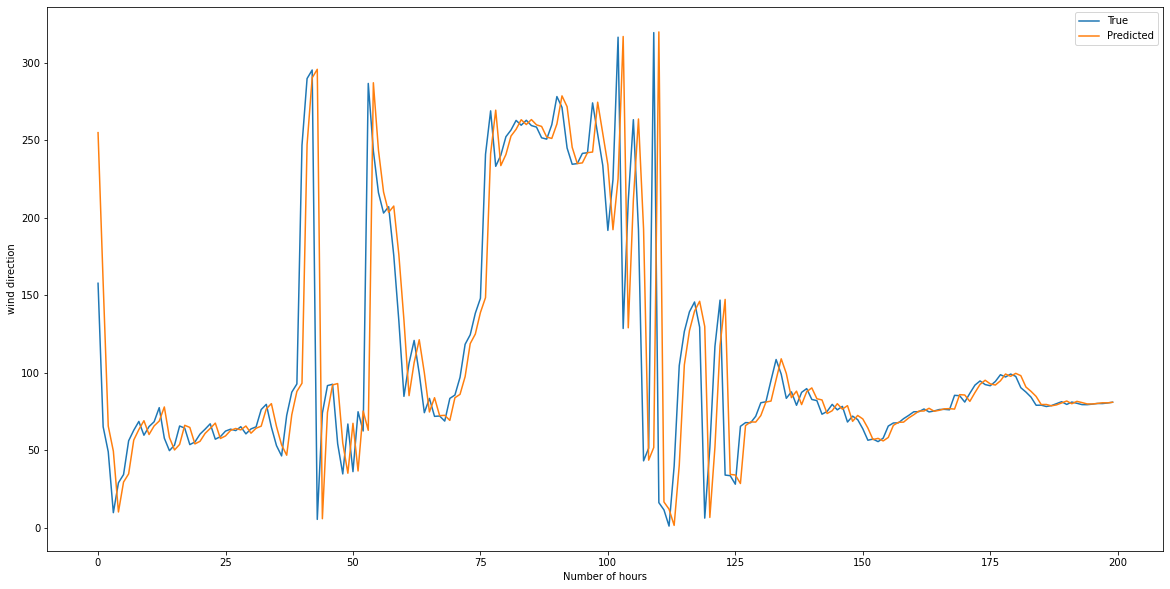

In [35]:
# line plot of observed vs predicted
fig = pyplot.figure(figsize=(20,10))
pyplot.plot(raw_values[-200:], label="True")
pyplot.plot(predictions[-200:], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("wind direction")
pyplot.show()


In [22]:
# import pickle 

In [23]:
Pkl_Filename = "Pickle_RL_Model.h5"  
 
lstm_model.save(Pkl_Filename)

In [24]:
from keras.models import load_model 
    
Pickled_LR_Model = load_model(Pkl_Filename)

Pickled_LR_Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   3320      
                                                                 
 dense (Dense)               (1, 50)                   550       
                                                                 
Total params: 3,870
Trainable params: 3,870
Non-trainable params: 0
_________________________________________________________________


In [25]:
from sklearn.metrics import r2_score, mean_squared_error

print(len(expectations))
print(len(predictions))

print('R2', r2_score(expectations, predictions))

# score = Pickled_LR_Model.evaluate(np.asarray(train).astype(np.int32), np.asarray(test).astype(np.float32))   
# # Print the Score
# print("Test score: {0:.2f} %".format(100 * score))  

# # Predict the Labels using the reloaded Model
# Ypredict = Pickled_LR_Model.predict(test)  

# Ypredict
     

5992
5992
R2 0.8598357147889946
